# Chapter 7 Investigation of Cross-Frequency Coupling in a Local Field Potential

## Step 1 Visual inspection

### Load the data

In [1]:
load('Ch7-LFP-1.mat')

### Plot LFP

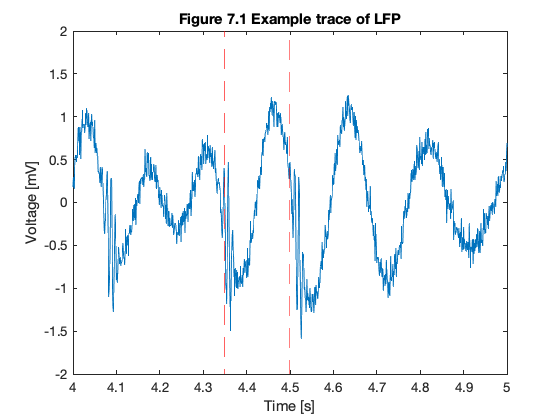

In [2]:
figure
plot(t, LFP)
axis([4 5 -2 2])
hold on
plot(ones(2, 1) * [4.35, 4.5], ylim' * ones(1, 2), 'r--')
xlabel('Time [s]')
ylabel('Voltage [mV]')
title('Figure 7.1 Example trace of LFP')


## Step 2 Estimate power spectrum

### 2.1 Using classic FFT

In [3]:
dt=t(2)-t(1);
Fs=1/dt;
fNQ = Fs / 2;
T=t(end);
N=length(LFP);

#### estimate FFT using Hanning window

In [4]:
x = hann(N) .* transpose(LFP);
xf = fft(x - mean(x)); % zero-mean process
Sxx = 2 * dt^2 / T * (xf .* conj(xf));
Sxx = Sxx(1:N / 2 + 1);


#### plot the power spectrum

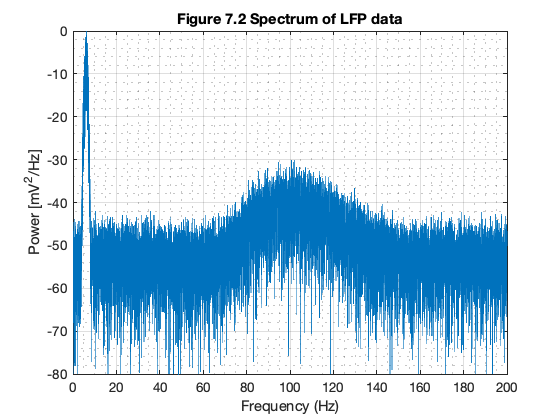

In [5]:
df = 1 / max(T);
faxis = (0:df:fNQ);
plot(faxis, 10 * log10(Sxx))
xlim([0 200])
ylim([-80 0])
grid on
grid minor
xlabel('Frequency (Hz)')
ylabel('Power [mV^2/Hz]')
title('Figure 7.2 Spectrum of LFP data')


### 2.2 Using multitaper method to estimate spectrum

#### add directories

In [6]:
% on cortex
addpath(genpath('~/Documents/Richard/Projects/rochester/mayo_clinic/nonuniform_signal'))

#### estimate spectrum

In [7]:
TW = 40;
f_qf = 0:.1:fNQ / 2;
nus = NUSpectrum(x - mean(x), t);
J = nus.mtnufft('QuerryFrequencies', f_qf, 'TimeHalfbandwidth', TW);
J = J / 3.5/10;


#### plot

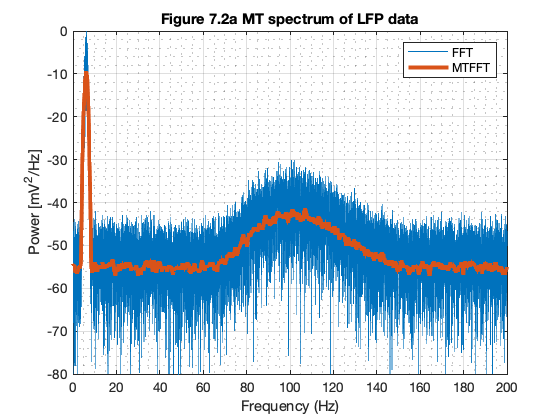

In [8]:
pxx = mean(J .* conj(J), 2);
figure
h_fft = plot(faxis, pow2db(Sxx));
hold on
h_mt = plot(f_qf, pow2db(pxx), 'LineWidth', 3);
xlim([0 200])
ylim([-80 0])
grid on
grid minor
legend([h_fft, h_mt], ["FFT", "MTFFT"])
xlabel('Frequency (Hz)')
ylabel('Power [mV^2/Hz]')
title('Figure 7.2a MT spectrum of LFP data')


#### F-test of periodicity

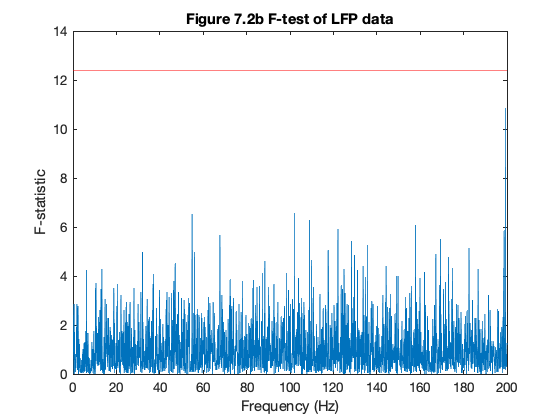

In [9]:
Fval = nus.nuftest(QuerryFrequencies = f_qf, TimeHalfbandwidth = TW);
Nr = 2 * fNQ / df;
K = 2 * TW - 1;
sig = finv(1 - 1 / Nr, 2, 2 * K - 2);

figure
plot(f_qf, Fval)
hold on
plot(xlim, ones(1, 2) * sig, 'r')
xlim([0, 200])
xlabel('Frequency (Hz)')
ylabel('F-statistic')
title('Figure 7.2b F-test of LFP data')


## Step 3 Cross-frequency coupling

### Filtering the data into high- and low-frequency bands

In [10]:
% for low-frequency interval
Wn = [5, 7] / fNQ; % set the passband
n = 100; % filter order
b = fir1(n, Wn);
Vlo = filtfilt(b, 1, LFP); % apply the filter

In [11]:
% for high-frequency interval
Wn = [80, 120] / fNQ;
b = fir1(n, Wn);
Vhi = filtfilt(b, 1, LFP);

#### plot Figure 7.3

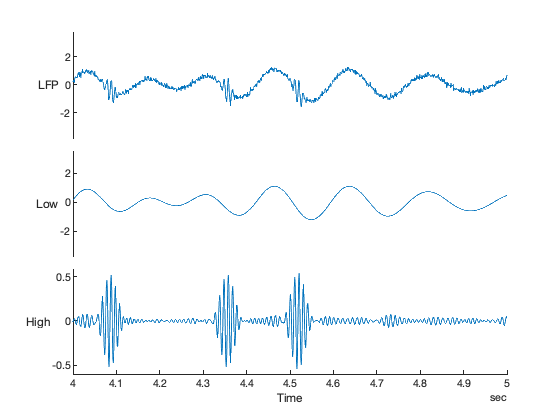

In [19]:
% make the timetable
D = timetable(LFP', Vlo', Vhi', 'RowTimes', seconds(t'), ...
'VariableNames', ["LFP", "Low", "High"]);

% stacked plot
figure
stackedplot(D)
xlim(seconds([4 5]))
